# MMIK lab 9

## Zadanie 1

In [74]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit.visualization import array_to_latex

### Implementacja

#### Rozwiązanie "książkowe"

In [5]:
n = 2
grover_by_the_book = QuantumCircuit(n + 1)

# przed wyrocznią
grover_by_the_book.x(2)
grover_by_the_book.h(0)
grover_by_the_book.h(1)
grover_by_the_book.h(2)

# wyrocznia
grover_by_the_book.ccx(0,1,2)

# po wyroczni - inwersja
grover_by_the_book.h(0)
grover_by_the_book.h(1)

grover_by_the_book.x(0)
grover_by_the_book.x(1)

grover_by_the_book.h(1)
grover_by_the_book.cx(0,1)
grover_by_the_book.h(1)

grover_by_the_book.x(0)
grover_by_the_book.x(1)

grover_by_the_book.h(0)
grover_by_the_book.h(1)




grover_by_the_book.draw()

┌───┐          ┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├───────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤       │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_1: ┤ H ├───────■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     ├───┤┌───┐┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘
q_2: ┤ X ├┤ H ├┤ X ├───────────────────────────────────
     └───┘└───┘└───┘

#### Rozwiązanie IBM

In [10]:
n = 2
grover_circuit = QuantumCircuit(n)

In [14]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [12]:
grover_circuit = initialize_s(grover_circuit, [0,1])

# Oracle
grover_circuit.cz(0,1) 

# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

### Działanie na symulatorach

#### Rozwiązanie "książkowe"

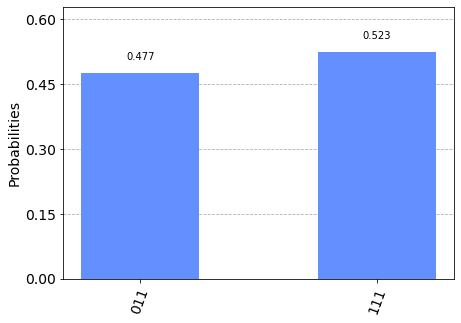

In [6]:
grover_by_the_book.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_by_the_book)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

#### Rozwiązanie IBM

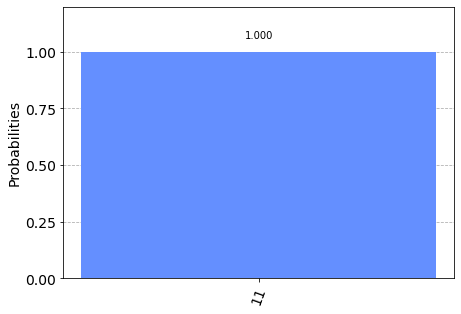

In [13]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

### Działanie na prawdziwym urządzeniu

In [7]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibm_nairobi


#### Rozwiązanie "książkowe"

In [8]:
transpiled_grover_by_the_book = transpile(grover_by_the_book, device, optimization_level=3)
job = device.run(transpiled_grover_by_the_book)
job_monitor(job, interval=2)

Job Status: job has successfully run


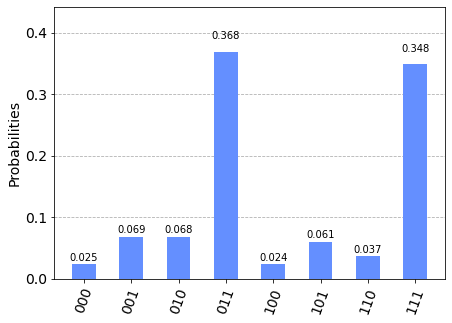

In [9]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_by_the_book)
plot_histogram(answer)

#### Rozwiązanie IBM

In [21]:
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


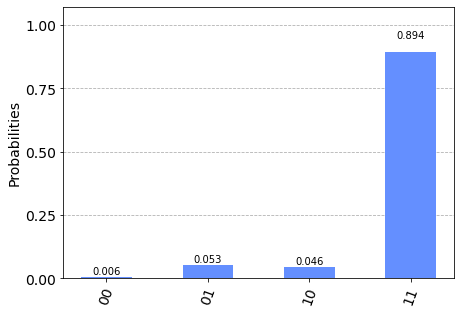

In [22]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

## Zadanie 2

In [66]:
from qiskit.circuit.library import MCMT

# wyrocznia rozpoznająca 111
qc = QuantumCircuit(3)
oracle_ex3 = MCMT('cz',2,1)
oracle_ex3.name = "U$_\omega$"
oracle_ex3.draw()

q_0: ─■─
      │ 
q_1: ─■─
      │ 
q_2: ─■─

In [67]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [68]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        ││             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        ││             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════════════════════════════════════════════╩══╩══╩═
                                                                   0  1  2

#### Amplitudy

In [76]:
from qiskit import execute

aer_sim = Aer.get_backend('statevector_simulator')
result = execute(grover_circuit, aer_sim).result().get_statevector()
array_to_latex(result)


<IPython.core.display.Latex object>